In [2]:
# convert data
import os
import numpy as np
import pickle as pkl
import torch
from torchvision.utils import save_image

file_header = 'csci-ua-473-intro-to-machine-learning-fall-2022'
trainx = torch.load(file_header + '/train/train/trainX.pt')
trainy = torch.load(file_header + '/train/train/trainY.pt')
testx = torch.load(file_header + '/test/test/testX.pt')

num_train = trainx[0].shape[0]
num_test = testx[0].shape[0]

os.makedirs('./lazydata', exist_ok=True)

# Save train data
os.makedirs('./lazydata/train', exist_ok=True)
os.makedirs('./lazydata/train/X', exist_ok=True)
os.makedirs('./lazydata/train/Y', exist_ok=True)
for i in range(num_train):
    os.makedirs('./lazydata/train/X/{}'.format(i), exist_ok=True)
    # rgb
    os.makedirs('./lazydata/train/X/{}/rgb'.format(i), exist_ok=True)
    for j in range(3):
        save_image(trainx[0][i][j]/255, './lazydata/train/X/{}/rgb/{}.png'.format(i, j))
    # depth
    depth = trainx[1][i].numpy()
    np.save('./lazydata/train/X/{}/depth.npy'.format(i), depth)
    # field id
    pkl.dump(trainx[2][i], open('./lazydata/train/X/{}/field_id.pkl'.format(i), 'wb'))

    y = trainy[0][i].numpy()
    np.save('./lazydata/train/Y/{}.npy'.format(i), y)
print("Saved train data")

# Save test data
os.makedirs('./lazydata/test', exist_ok=True)
os.makedirs('./lazydata/test/X', exist_ok=True)
for i in range(num_test):
    os.makedirs('./lazydata/test/X/{}'.format(i), exist_ok=True)
    # rgb
    os.makedirs('./lazydata/test/X/{}/rgb'.format(i), exist_ok=True)
    for j in range(3):
        save_image(testx[0][i][j]/255, './lazydata/test/X/{}/rgb/{}.png'.format(i, j))
    # depth
    depth = testx[1][i].numpy()
    np.save('./lazydata/test/X/{}/depth.npy'.format(i), depth)
    # field id
    pkl.dump(testx[2][i], open('./lazydata/test/X/{}/field_id.pkl'.format(i), 'wb'))

print("Saved test data")

Saved train data
Saved test data


In [5]:
import cv2
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [9]:
# lazy loading data
class LazyLoadDataset(Dataset):
    def __init__(self, path, train = True, transform = None):
        self.transform = transform
        path = path + ('train/' if train else 'test/')

        self.pathX = path + 'X/'
        self.pathY = path + 'Y/'

        self.data = os.listdir(self.pathX)
    
    def __getitem__(self, index):
        f = self.data[index]

        # X
        # read rgb images
        img0 = cv2.imread(self.pathX + f + '/rgb/0.png')
        img1 = cv2.imread(self.pathX + f + '/rgb/1.png')
        img2 = cv2.imread(self.pathX + f + '/rgb/2.png')

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        # read depth
        depth = np.load(self.pathX + f + '/depth.npy')

        #read field id
        field_id = pkl.load(open(self.pathX + f + '/field_id.pkl', 'rb'))

        # Y
        Y = np.load(self.pathY + f + '.npy')
        
        return (img0, img1, img2, depth, field_id), Y
    
    def __len__(self):
        return len(self.data)

In [10]:
dataset = LazyLoadDataset('./lazydata/')

In [11]:
(img0, img1, img2, depth, field_id), Y = dataset[0]

In [27]:
type(img0)

numpy.ndarray

In [14]:
field_id

'1573'

In [15]:
Y.shape

(12,)

In [16]:
Y

array([ 0.0486987 ,  0.05146899,  0.12119602,  0.05379465, -0.00211509,
        0.11356296,  0.06531687, -0.05045136,  0.09290361,  0.05493185,
       -0.02291667, -0.06235145])

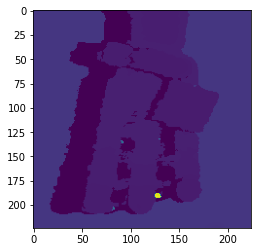

In [26]:
import matplotlib.pyplot as plt
# plt.imshow(img0[:,:,::-1])
plt.imshow(depth[0])
plt.show()